In [ ]:
### GoogleDriveへの接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **以下、データ加工（反復写像図の作成）**

In [ ]:
### 必要ライブラリのインポート
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter # フィルター用


In [ ]:
### Google driveにあるファイルのパス情報
# cuff less blood pressure estimationデータセットダウンロード
drive_file1 = "/content/drive/MyDrive/cuff_less_blood_pressure_matlabfiles/Part_1.mat"
drive_file2 = "/content/drive/MyDrive/cuff_less_blood_pressure_matlabfiles/Part_2.mat"
drive_file3 = "/content/drive/MyDrive/cuff_less_blood_pressure_matlabfiles/Part_3.mat"
drive_file4 = "/content/drive/MyDrive/cuff_less_blood_pressure_matlabfiles/Part_4.mat"

drive_files = [drive_file1, drive_file2, drive_file3, drive_file4]

In [ ]:
### 全データ読み込み
import h5py
import numpy as np

# 結果を格納するリスト
data_list = []

# matファイルからデータを読み込み、numpy形式で全データをdata_listに格納
for idx, drive_file in enumerate(drive_files):
  with h5py.File(drive_file, "r") as f:
      print(list(f.keys()))  # e.g. ['#refs#', 'Part_1']
      data_group = f[f'Part_{idx + 1}']
      print(data_group.shape,"data_group")
      # ファイル構造＝(3000，1）3000はデータ件数

     # すべてのセルを読み込む
      for i in range(data_group.shape[0]):
          ref = data_group[i][0]     # セルの参照を取得
          dataset = f[ref]           # 実データにアクセス
          arr = dataset[:]           # NumPy配列に変換
          arr = arr.T                # 転置
          data_list.append(arr)      # リストに格納



# 例として最初のデータの形状と内容を表示
print(f"Total records: {len(data_list)}")
print(f"Shape of data_list[0].shape: {data_list[0].shape}")
print(data_list[0])

In [ ]:
### バターワースフィルタ
import numpy as np
from scipy import signal

def butter_bandpass_sos(lowcut, highcut, fs, order=4):
    """
    2次節(SOS)でバターワースバンドパスを設計して返す。
    lowcut, highcut: Hz
    fs: サンプリング周波数 (Hz)
    order: フィルタ次数（総次数、ここでは4を指定すると4次）
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if not (0 < low < high < 1):
        raise ValueError(f"lowcut/highcut が不正です (low={lowcut}, high={high}, fs={fs})")
    # SOS 出力で設計（数値安定性が良い）
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    return sos

def apply_zero_phase_sosfilt(sos, data):
    """
    sos を使ってゼロ位相（双方向）フィルタリングを行う。
    入力が短すぎる場合は sosfilt（片方向）で代替する。
    """
    # sosfiltfilt のパディング長は内部で計算されるが、
    # scipy の filtfilt と同様 padlen が必要になることがあるためチェック
    try:
        # sosfiltfilt が利用可能ならこれを使うのが最も安全
        y = signal.sosfiltfilt(sos, data)
    except Exception as e:
        # 短い信号やバージョン差異で失敗したら sosfilt に落とす（位相は残る）
        # その場合、前後反転して2回かける手法（簡易ゼロ位相信号復元）でも試せるが、
        # ここでは単純に sosfilt を返す
        y = signal.sosfilt(sos, data)
    return y

def butter_bandpass_filter(data, lowcut=0.5, highcut=8.0, fs=100.0, order=4):
    """
    簡易ラッパー：データ配列に対して 0.5-8Hz (default) の4次バターワースバンドパスを適用。
    data: 1D numpy array
    fs: サンプリング周波数 (Hz)
    """
    sos = butter_bandpass_sos(lowcut, highcut, fs, order=order)
    return apply_zero_phase_sosfilt(sos, data)


In [ ]:
### データセット平滑化(PPGをバターワースフィルタへ)
fs = 125.0
for idx, arr in enumerate(data_list):
  smoothed_ppg = butter_bandpass_filter(arr[0], lowcut=0.5, highcut=8.0, fs=fs, order=4)
  data_list[idx][0] = smoothed_ppg

In [ ]:
### 速度脈波、加速度脈波作成
# ステップサイズ（h）

fs = 125.0 # サンプリング周波数

t = 1 / fs
vppg_list_before = []
appg_list_before = []

for idx, arr in enumerate(data_list):
  vppg_list_before.append(np.gradient(arr[0], t))
  appg_list_before.append(np.gradient(vppg_list_before[idx], t))

print(len(vppg_list_before))
print(len(appg_list_before))
print(vppg_list_before[0].shape)
print(appg_list_before[0].shape)
#data_list.append(np.array(vppg_list_before))
#data_list.append(np.array(appg_list_before))

#print(data_list.shape)

In [ ]:
### データリストの分割（180秒（fs*180)ごとに分割し、新しくリストに格納）

chunk_size = 125 * 180  # 分割チャンクサイズ（180ごと）

ppg_data_list_row = []  # ppgデータ群
abp_data_list_row = []  # sbpデータ群

vppg_data_list_row = [] # vppgデータ群
appg_data_list_row = [] # appgデータ群

# data_listをチャンクサイズで分割
for record_idx, arr in enumerate(data_list):
    # 何チャンク作れるか
    n_chunks = arr.shape[1] // chunk_size

    if(n_chunks == 0): # データの長さがチャンク数を下回る場合はスキップ
      continue

    for chunk_idx in range(n_chunks):
        start = chunk_idx * chunk_size
        end   = start + chunk_size

        # 1 行目が ppg、2 行目が abp
        ppg = arr[0, start:end]
        abp = arr[1, start:end]
        vppg = vppg_list_before[record_idx][start:end]
        appg = appg_list_before[record_idx][start:end]

        ppg_data_list_row.append(ppg)
        abp_data_list_row.append(abp)
        vppg_data_list_row.append(vppg)
        appg_data_list_row.append(appg)

# 確認
print(f"ppgチャンク数: {len(ppg_data_list_row)}")
print(f"sbpチャンク数: {len(abp_data_list_row)}")
print(f"vppgチャンク数: {len(vppg_data_list_row)}")
print(f"appgチャンク数: {len(appg_data_list_row)}")

# 確認
print(f"全レコード数：{len(ppg_data_list_row)}")
print(f"全レコード数：{len(abp_data_list_row)}")
print(f"全レコード数：{len(vppg_data_list_row)}")
print(f"全レコード数：{len(appg_data_list_row)}")
print(f"ppg_data_list_row[0].shape = {ppg_data_list_row[0].shape}")
print(f"abp_data_list_row[0].shape = {abp_data_list_row[0].shape}")
print(f"vppg_data_list_row[0].shape = {vppg_data_list_row[0].shape}")
print(f"appg_data_list_row[0].shape = {appg_data_list_row[0].shape}")
print(f"最初のデータ ppg ={ppg_data_list_row[:10]}")
print(f"最初のデータ abp ={abp_data_list_row[:10]}")
print(f"最初のデータ vppg ={vppg_data_list_row[:10]}")
print(f"最初のデータ appg ={appg_data_list_row[:10]}")

In [ ]:
### データを正しく読み込めているか確認
# データセットPart1の最初のレコード10列目まで表示
print(f"最初のデータ ppg ={ppg_data_list_row[0][:10]}")
print(f"最初のデータ abp ={abp_data_list_row[0][:10]}")

In [ ]:
### SBP推定
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# サンプリング周波数（cuff less blood pressure estimation データセット）
fs = 125

# ピークを見つける
def find_all_peaks(abp_data_list):
    peaks_list = []
    # 間隔 (0.5秒ごと)
    distance = int(fs * 0.5)

    for abp in abp_data_list:
      n = len(abp)
      t = np.arange(n) / fs
      abp_median = np.median(abp)
      abp_min = np.min(abp)
      delta = abp_median - abp_min

      peaks, props = find_peaks(abp,distance=distance, prominence= delta)
      #peaks,props = find_peaks(abp, height=70, distance=distance,prominence=10.0,width=10)
      peaks_list.append(peaks)
    return peaks_list

# SBP推定 (前ピークの平均値)
def calculate_sbp(peaks_list,abp_data_list):
    sbp_data_list = []

    for id,peaks in enumerate(peaks_list):
      sbp_mean = np.mean(abp_data_list[id][peaks])
      sbp_data_list.append(sbp_mean)
    return sbp_data_list

# DBP推定（ピーク間の最小値）
def find_all_dbp(peaks_list,abp_data_list):
  dbp_data_mean_list = []
  for id,peaks_sbp in enumerate(peaks_list):
    dbp_data_all_list = []
    # 最初のピークから最後のピークまで繰り返す
    for i in range(len(peaks_sbp) - 1):
    # 連続する2つのSBPピークのインデックスを取得
      start_index = peaks_sbp[i]
      end_index = peaks_sbp[i+1]

      # 2つのピーク間の信号セグメントを抽出
      segment = abp_data_list[id][start_index : end_index + 1] # +1 は end_index を含めるため

      # セグメント内の最小値を見つける
      dbp_segment = np.min(segment)
      dbp_data_all_list.append(dbp_segment)

    dbp_data_mean_list.append(np.mean(dbp_data_all_list))

  return dbp_data_mean_list

# ピークのidリスト
peaks_list = find_all_peaks(abp_data_list_row)
# 各ピークの平均値（SBP)
sbp_data_list_row = calculate_sbp(peaks_list, abp_data_list_row)
# DBP（ピーク間の最小値）
dbp_data_list_row = find_all_dbp(peaks_list, abp_data_list_row)

# 確認
print(len(sbp_data_list_row))
print(len(dbp_data_list_row))
print(sbp_data_list_row[:10])
print(dbp_data_list_row[:10])


In [ ]:
### 異常値削除
remove_idx_list = []
for idx, (sbp, dbp) in enumerate(zip(sbp_data_list_row, dbp_data_list_row)):
  ranges = abs(sbp - dbp) # 絶対値を使用
  if sbp < 80 or sbp > 190:
    remove_idx_list.append(idx)

  elif dbp < 50 or dbp > 120:
    remove_idx_list.append(idx)

  elif ranges < 20 or ranges > 120:
    remove_idx_list.append(idx)

print(len(remove_idx_list))
remove_idx_list = list(set(remove_idx_list))
remove_idx_list.sort()
print(len(remove_idx_list))
print(remove_idx_list[:10])

print("--------------------------------------------")
# 異常値をリストから削除
print(f'削除前PPG{len(ppg_data_list_row)}')
ppg_data_list = [item for index, item in enumerate(ppg_data_list_row) if index not in remove_idx_list]
print(f'削除後PPG{len(ppg_data_list)}')

print("--------------------------------------------")

print(f'削除前ABP{len(abp_data_list_row)}')
abp_data_list = [item for index, item in enumerate(abp_data_list_row) if index not in remove_idx_list]
print(f'削除後ABP{len(abp_data_list)}')

print("--------------------------------------------")

print(f'削除前VPPG{len(vppg_data_list_row)}')
vppg_data_list = [item for index, item in enumerate(vppg_data_list_row) if index not in remove_idx_list]
print(f'削除後VPPG{len(vppg_data_list)}')

print("--------------------------------------------")

print(f'削除前APPG{len(appg_data_list_row)}')
appg_data_list = [item for index, item in enumerate(appg_data_list_row) if index not in remove_idx_list]
print(f'削除後APPG{len(appg_data_list)}')

print("--------------------------------------------")

print(f'削除前sbp{len(sbp_data_list_row)}')
sbp_data_list = [item for index, item in enumerate(sbp_data_list_row) if index not in remove_idx_list]
print(f'削除後sbp{len(sbp_data_list)}')




In [ ]:
### sbp140mmhg未満と以上で分ける
above140_idx_list = []
below140_idx_list = []

for idx, sbp in enumerate(sbp_data_list):
  if sbp >= 140:
    above140_idx_list.append(idx)
  else:
    below140_idx_list.append(idx)

print(len(above140_idx_list))
print(len(below140_idx_list))
print(above140_idx_list[:10])
print(below140_idx_list[:10])

In [ ]:
### 反復写像図作成　本物
from tqdm import tqdm
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os

def make_return_pairs(data, fs, tau_seconds, offset=0):
    """
    τ秒ごとに離散サンプリングして対を作る。
    - data: 1D array-like (list or np.array)
    - fs: サンプリング周波数 [Hz]
    - tau_seconds: 遅延時間 τ [秒]
    - offset: 0 <= offset < tau_samples。開始インデックスのオフセット（データを増やしたい時に複数のオフセットで呼ぶ）
    Returns (M_n, M_n_plus_1) as numpy arrays.
    """
    if tau_seconds <= 0:
        raise ValueError("tau_seconds must be > 0")

    tau_samples = int(tau_seconds * fs) #　間隔t=0.1なら12個　小数点以下切り捨て

    if tau_samples <= 0:
        raise ValueError("tau_seconds * fs < 0.5 -> tau_samples == 0 になりました。fs と tau_seconds を確認してください。")

    if offset < 0 or offset >= tau_samples:
        raise ValueError("offset must satisfy 0 <= offset < tau_samples")

    N = data.size
    # k = 0,1,... でインデックス = offset + k * tau_samples が有効な範囲
    last_valid_start = N - tau_samples - offset
    if last_valid_start < 0:
        # 十分な長さがない
        return np.array([]), np.array([])

    k_indices = np.arange(offset, N - tau_samples, tau_samples)
    M_n = data[k_indices]
    M_n_plus_1 = data[k_indices + tau_samples]
    #print(M_n[:5])
    #print(M_n_plus_1[:5])
    return M_n, M_n_plus_1


def plot_return_map_decimated(M_n, M_n_plus_1, out_path, class_name, idx, fig, ax, type):
    """
    与えられたペアを散布図として保存する（余白ゼロ、軸非表示）。
    - M_n, M_n_plus_1: numpy arrays
    - out_path: 保存ディレクトリ
    - fname: ファイル名（拡張子含む例: 'above_idx_12.png'）
    - figsize: inch 単位（例 2.24inch * 100dpi = 224px）
    - dpi: 保存時の DPI
    """
    #os.makedirs(out_path, exist_ok=True)
    #fig, ax = plt.subplots(figsize=figsize)
    if M_n.size == 0:
        raise ValueError("M_n.size == 0 になりました。") # エラー投げ
        return

    vmin = np.min(M_n)
    vmax = np.max(M_n_plus_1)

    #ax.scatter(M_n, M_n_plus_1, s=1, alpha=0.7, marker='.')
    ax.plot(M_n, M_n_plus_1, '.', markersize=0.5, alpha=1)

    # ▷ 軸の設定（スケールと範囲）
    ax.set_aspect('equal')
    ax.set_xlim([vmin, vmax])
    ax.set_ylim([vmin, vmax])

    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.savefig(f'{out_path}/{class_name}_type_{type}_idx_{idx}.png')

    ax.cla()    #グラフ（軸）をリセット

# ループにより脈波データ集を反復写像図に
tau = 0.1 # タウ

root_path = f'/content/反復写像図_standard=sbp140_len=22500_t={tau}'
above_path = f'/content/反復写像図_standard=sbp140_len=22500_t={tau}/above_sbp140'
below_path = f'/content/反復写像図_standard=sbp140_len=22500_t={tau}/below_sbp140'

above_class = 'above_sbp'
below_class = 'below_sbp'

import os
os.makedirs(root_path, exist_ok=True)
os.makedirs(above_path, exist_ok=True)
os.makedirs(below_path, exist_ok=True)

fs = 125 # サンプリング周波数
fig, ax = plt.subplots(figsize=(2.24, 2.24))     # figure, axis作成

# above140グループの画像作成
for idx in tqdm(above140_idx_list):
 # ノーマル脈波を変換する場合（コメント解除する）
 #M_n, M_n_plus_1 = make_return_pairs(ppg_data_list[idx], fs, tau)
 #plot_return_map_decimated(M_n, M_n_plus_1, above_path, above_class, idx, fig, ax, "ppg")

 # VPPGを変換する場合
 #M_n, M_n_plus_1 = make_return_pairs(vppg_data_list[idx], fs, tau)
 #plot_return_map_decimated(M_n, M_n_plus_1, above_path, above_class, idx, fig, ax, "vppg")

 # APPGを変換する場合
 M_n, M_n_plus_1 = make_return_pairs(appg_data_list[idx], fs, tau)
 plot_return_map_decimated(M_n, M_n_plus_1, above_path, above_class, idx, fig, ax, "appg")


# below140グループの画像作成
for idx in tqdm(below140_idx_list):
 # ノーマル脈波を変換する場合
 #M_n, M_n_plus_1 = make_return_pairs(ppg_data_list[idx], fs, tau)
 #plot_return_map_decimated(M_n, M_n_plus_1, below_path, below_class, idx, fig, ax, "ppg")

 # VPPGを変換する場合
 #M_n, M_n_plus_1 = make_return_pairs(vppg_data_list[idx], fs, tau)
 #plot_return_map_decimated(M_n, M_n_plus_1, below_path, below_class, idx, fig, ax, "vppg")

 # APPGを変換する場合
 M_n, M_n_plus_1 = make_return_pairs(appg_data_list[idx], fs, tau)
 plot_return_map_decimated(M_n, M_n_plus_1, below_path, below_class, idx, fig, ax, "appg")


In [ ]:
### 作成したデータセットファイルの確認
# ファイル数を調べたいフォルダのパス
above_path = "/content/反復写像図_standard=sbp140_len=22500_t=0.1/above_sbp140"
below_path = "/content/反復写像図_standard=sbp140_len=22500_t=0.1/below_sbp140"

# フォルダ内の全ファイル名をリスト化
above_files = os.listdir(above_path)
below_files = os.listdir(below_path)

# リストの長さ（ファイル数）を取得
above_count = len(above_files)
below_count = len(below_files)

# ファイル数を確認
print(above_count)
print(below_count)

In [ ]:
### zip圧縮
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/反復写像図_standard=sbp140_len=22500_t=0.1.zip /content/反復写像図_standard=sbp140_len=22500_t=0.1



In [ ]:
### 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/反復写像図_standard=sbp140_len=22500_t=0.1.zip")

# **以下、ConveNeXtによる学習**

In [ ]:
# 必要なライブラリをインストール
!pip install torchviz torchinfo
!apt install -y tree
!pip install -q tqdm
!pip install torch-lr-finder


# PyTorchと関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import numpy as np

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (159 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
### Transform定義

# 学習用（データ拡張＋正規化）
train_transform = transforms.Compose([
    # ランダムに切り抜き、224^2にリサイズ
    transforms.RandomResizedCrop((224,224),scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),

    # Tensor型に変換
    transforms.ToTensor(),
    # 正規化
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
    # ランダムに黒い矩形追加
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 検証、テスト用（データ拡張なし）
val_and_test_transform = transforms.Compose([
    #ピクセル数は変えない（224**2）

    # Tensor型に変換
    transforms.ToTensor(),
    # 正規化
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

In [ ]:
### ハイパーパラメータ一覧
from enum import StrEnum

## タグチメソッド用　調整対象パラメータ
# 学習方法
class Learning_Type(StrEnum):
    Transfer_Learning = "転移学習" # 転移学習
    Fine_Tuning = "ファインチューニング" # ファインチューニング

# 学習率
lr_1 = 5.00e-6
lr_2 = 5.00e-5
lr_3 = 1.00e-4

# バッチサイズ
batch_size_1 = 16
batch_size_2 = 32
batch_size_3 = 64

# エポック数
num_epochs_1 = 15
num_epochs_2 = 30
num_epochs_3 = 45

# Stochastic Depth
stochastic_depth_1 = 0.2
stochastic_depth_2 = 0.4
stochastic_depth_3 = 0.6

# Weight Decay
weight_decay_1 = 1.00e-10
weight_decay_2 = 1.00e-8
weight_decay_3 = 1.00e-6

# サンプル画像
class Sample_Type(StrEnum):
  PPG = "PPG" # ノーマル脈波
  VPPG = "VPPG" # 速度脈波（一回微分）
  APPG = "APPG" # 加速度脈波（二階微分）


# シード値（パラメータではない）
seed_1 = 42
seed_2 = 810
seed_3 = 114514

In [ ]:
# ハイパーパラメータの水準を選択

# 学習方法
learning_type = Learning_Type.Fine_Tuning # ファインチューニング

# 学習率
#learning_rate = lr_1 # 5.00e-6
learning_rate = lr_2 # 5.00e-5
#learning_rate = lr_3 # 1.00e-4

# バッチサイズ
#batch_size = batch_size_1 # 16
batch_size = batch_size_2 # 32
#batch_size = batch_size_3 # 64

# エポック数
#num_epochs = num_epochs_1 # 15
num_epochs = num_epochs_2 # 30
#num_epochs = num_epochs_3 # 45

# Stochastic Depth
stochastic_depth = stochastic_depth_1 # 0.2
#stochastic_depth = stochastic_depth_2 # 0.4
#stochastic_depth = stochastic_depth_3 # 0.6

# Weight Decay
#weight_decay = weight_decay_1 # 1.00e-10
weight_decay = weight_decay_2 # 1.00e-8
#weight_decay = weight_decay_3 # 1.00e-6

# サンプル画像
sample_type = Sample_Type.PPG # ノーマル脈波
#sample_type = Sample_Type.VPPG # 速度脈波
#sample_type = Sample_Type.APPG # 加速度脈波

# 乱数固定化
#seed = seed_1 # 1回目
#seed = seed_2 # 2回目
seed = seed_3 # 3回目

# 現在のハイパーパラメータ設定を表示
print(f"Now Learning_Type = {learning_type}")
print(f"Now Learning_Rate = {learning_rate}")
print(f"Now Batch_Size = {batch_size}")
print(f"Now Num_Epochs = {num_epochs}")
print(f"Now Stochastic_Depth = {stochastic_depth}")
print(f"Now Weight_Decay = {weight_decay}")
print(f"Now Sample_Type = {sample_type}")

# シード
print(f"Now Seed = {seed}")

Now Learning_Type = ファインチューニング
Now Learning_Rate = 5e-05
Now Batch_Size = 32
Now Num_Epochs = 30
Now Stochastic_Depth = 0.2
Now Weight_Decay = 1e-08
Now Sample_Type = PPG
Now Seed = 114514


In [ ]:
### 学習データをロード

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import torch
from torchvision import datasets

# ファイルパス
PPG_Path = "/content/drive/MyDrive/反復写像図_バターワースフィルタ_sbp調整_180_ppg/反復写像図_standard=sbp140_len=22500_t=0.1" # ノーマル脈波
VPPG_Path = "/content/drive/MyDrive/反復写像図_バターワースフィルタ_sbp調整_180_vppg/反復写像図_standard=sbp140_len=22500_t=0.1" # VPPG
APPG_Path = "/content/drive/MyDrive/反復写像図_バターワースフィルタ_sbp調整_180_appg/反復写像図_standard=sbp140_len=22500_t=0.1" # APPG



# サンプル画像選択
if(sample_type == Sample_Type.PPG):
  full_file_path = PPG_Path
elif(sample_type == Sample_Type.VPPG):
  full_file_path = VPPG_Path
elif(sample_type == Sample_Type.APPG):
  full_file_path = APPG_Path
else:
  raise ValueError("sample_type が正しく設定されていません")

# 現在の画像タイプ表示
print(f"now file path:{full_file_path}")



# データセット取得
# 学習用（データ拡張あり）
train_dataset = datasets.ImageFolder(
    root = full_file_path,
    transform = train_transform
)

# 検証、テスト用（データ拡張なし）
val_and_test_dataset = datasets.ImageFolder(
    root = full_file_path,
    transform = val_and_test_transform
)



# ファイル順序が揃っているか確認
paths1 = [s[0] for s in train_dataset.samples]
paths2 = [s[0] for s in val_and_test_dataset.samples]
print(f"ファイル順序が同じか：{paths1 == paths2}")

# train_datasetのIDリスト取得
targets = np.array(train_dataset.targets)

# 再現性のためのシード
print(f"Now Seed = {seed}")
rng = np.random.RandomState(seed)

# 元データのクラス分布（確認用）
orig_counts = Counter(targets)
print("Original class counts:", orig_counts)


# 分割比を決める（例：訓練70%, 検証15%, テスト15%）
n_total = len(train_dataset)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15


# まず train と 残り(temp=val+test) に層化分割(クラスの比率を保ったまま分割)
idx = np.arange(n_total)
train_idx, temp_idx = train_test_split(
    idx,
    test_size=(1.0 - train_ratio),
    stratify=targets,
    random_state=seed,
)

# 残り(temp)を val と test に層化分割(クラスの比率を保ったまま分轄)
temp_targets = targets[temp_idx]
test_size_in_temp = test_ratio / (val_ratio + test_ratio)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=test_size_in_temp,
    stratify=temp_targets,
    random_state=seed,
)

# 学習、検証、テストデータセット作成
# 各IDリストに対応するファイルを、それぞれのDatasetからインポート
train_ds = Subset(train_dataset, train_idx)
val_ds   = Subset(val_and_test_dataset,  val_idx)
test_ds  = Subset(val_and_test_dataset,  test_idx)

# 各データセットのクラス分布を確認
def count_by_class(subset):
    labels = [train_dataset.samples[i][1] for i in subset.indices]
    return Counter(labels)

print(train_dataset.class_to_idx)
print(val_and_test_dataset.class_to_idx)
print("Train size:", len(train_ds), "class counts:", count_by_class(train_ds))
print("Val   size:", len(val_ds),   "class counts:", count_by_class(val_ds))
print("Test  size:", len(test_ds),  "class counts:", count_by_class(test_ds))


now file path:/content/drive/MyDrive/反復写像図_バターワースフィルタ_sbp調整_180_ppg/反復写像図_standard=sbp140_len=22500_t=0.1
ファイル順序が同じか：True
Now Seed = 114514
Original class counts: Counter({np.int64(1): 6975, np.int64(0): 3303})
{'above_sbp140': 0, 'below_sbp140': 1}
{'above_sbp140': 0, 'below_sbp140': 1}
Train size: 7194 class counts: Counter({1: 4882, 0: 2312})
Val   size: 1542 class counts: Counter({1: 1046, 0: 496})
Test  size: 1542 class counts: Counter({1: 1047, 0: 495})


In [ ]:
print(train_dataset.class_to_idx)
print(val_and_test_dataset.class_to_idx)

In [ ]:
# データセットの画像を例示（確認用）
import matplotlib.pyplot as plt

# 分類先クラスのリスト作成
classes = ['above_sbp', 'below_sbp']

plt.figure(figsize=(15, 4))
for i in range(8):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_ds[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_ds[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
### サンプラー作成
### 訓練用データセットにおいて、クラス分布を均等にする
from torch.utils.data import WeightedRandomSampler

# ラベル情報取得
data_list_targets = np.array(train_ds.dataset.targets)

train_targets = np.array(data_list_targets[train_idx])

print(train_targets.shape)

# 各ラベルの頻度
class_counts = np.bincount(train_targets)   # [2000, 8000]

# サンプルごとの重み = 1 / クラスの頻度
sample_weights = 1.0 / class_counts[train_targets]
sample_weights = torch.tensor(sample_weights, dtype=torch.double)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

(7194,)


In [ ]:
### DataLoaderの作成
import os

# データ読み込みを並列化するプロセス数
num_workers = os.cpu_count() - 1
pin_memory   = True    # CUDA使用時に高速化（GPUに直接転送）

# バッチサイズ確認
print(f"Now Batch Size = {batch_size}")


# DataLoader の作成
train_loader = DataLoader(
    train_ds,      # Subset or ImageFolder
    batch_size=batch_size,
    #shuffle=True,       # サンプラーを使うので、シャッフルはなし
    num_workers=num_workers,
    pin_memory=pin_memory,
    sampler=sampler
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,      # 検証では順序固定
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,      # テストでは順序固定
    num_workers=num_workers,
    pin_memory=pin_memory
)

# 3) 動作確認
for images, labels in train_loader:
    print("  images:", images.shape)   # 例: [batch_size, 3, 224, 224]
    print("  labels:", labels)         # 例: tensor([0,1,0,1, …])
    break


Now Batch Size = 32
  images: torch.Size([32, 3, 224, 224])
  labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1])


In [ ]:
### 現在のランタイムタイプ確認
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


True
NVIDIA L4


In [ ]:
### 事前学習済みモデルインポート

import torch
import torch.nn as nn
from torchvision import models
import random
from torchvision.models import convnext_base, ConvNeXt_Base_Weights


# デバイス
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# シード
print(f"Now Seed = {seed}")

random.seed(seed)                    # Python 標準 random
np.random.seed(seed)                 # NumPy
torch.manual_seed(seed)              # PyTorch CPU
torch.cuda.manual_seed(seed)         # PyTorch GPU (CUDA)
torch.cuda.manual_seed_all(seed)     # 全GPUに適用
torch.backends.cudnn.benchmark = False # 畳み込み演算での再現性無視
torch.backends.cudnn.deterministic = True # 決定的なpytorchの操作

#stochastic_depth確認
print(f"Now Stochastic Depth = {stochastic_depth}")

# モデル
# 事前学習済み ConveNeXt_Base
# ダウンロード
model = convnext_base(weights= ConvNeXt_Base_Weights, stochastic_depth_prob= stochastic_depth)

# 事前学習をしていないモデルを使いたい場合は以下のコードを実行
# model = convnext_base(stochastic_depth_prob= stochastic_depth)

Now Seed = 114514
Now Stochastic Depth = 0.2


In [ ]:
# ConveNeXt_Baseのサマリー
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      [1, 1000]                 --
├─Sequential: 1-1                             [1, 1024, 7, 7]           --
│    └─Conv2dNormActivation: 2-1              [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-1                       [1, 128, 56, 56]          6,272
│    │    └─LayerNorm2d: 3-2                  [1, 128, 56, 56]          256
│    └─Sequential: 2-2                        [1, 128, 56, 56]          --
│    │    └─CNBlock: 3-3                      [1, 128, 56, 56]          138,496
│    │    └─CNBlock: 3-4                      [1, 128, 56, 56]          138,496
│    │    └─CNBlock: 3-5                      [1, 128, 56, 56]          138,496
│    └─Sequential: 2-3                        [1, 256, 28, 28]          --
│    │    └─LayerNorm2d: 3-6                  [1, 128, 56, 56]          256
│    │    └─Conv2d: 3-7                       [1, 256, 28, 28]          131

In [ ]:
# ConveNeXt_Baseのモデル構造
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
### モデル調整

if learning_type == Learning_Type.Transfer_Learning:
  # 転移学習の場合、すべてのパラメータで勾配計算なしに(効果なかったので使用せず)
  for param in model.parameters():
      param.requires_grad = False
elif learning_type == Learning_Type.Fine_Tuning:
  # ファインチューニングの場合（基本こっち）
  for param in model.parameters():
      param.requires_grad = True
else:
  raise ValueError("learning_type が正しく設定されていません")



# 最終層付け替え 出力を2次元に
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, len(train_ds.dataset.classes))

# 確認
for param in model.parameters():
   # print(param)
    print(param.requires_grad)

# 現在の学習方法表示
print(f"now learning type:{learning_type}")


# モデルの最終層
print(f'モデル最終層={model.classifier[-1]}')

# モデルの最終層入力サイズ
print(f'モデル最終層入力サイズ={model.classifier[-1].in_features}')

# 転送
model = model.to(device)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
### 損失関数、最適化関数設定

# 使わなかった部分
#--------------------------------------------------------------------------
# クラスの重み付け
#フルデータセットからクラスごとの数を取得
# クラスの出現数
#class_counts = torch.tensor([3303, 6975], dtype=torch.float32)
# 出現数の逆数を重みとして使う（少ないクラスを重視）
#class_weights = 1.0 / class_counts
#class_weights = class_weights / class_weights.sum()  # 正規化

# GPUに送る
#class_weights = class_weights.to(device)

#criterion = nn.CrossEntropyLoss(weight = class_weights)

#-------------------------------------------------------------------------- ここまで


# 損失関数　クロスエントロピー(ラベルスムージングあり)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


# 学習率確認
print(f"Now Learing Rate = {learning_rate}")

# Weight_Decay確認
print(f"Now Weight Decay = {weight_decay}")

# 最適化関数設定
# AdamWを使用
if learning_type == Learning_Type.Transfer_Learning:
  # 転移学習の場合（効果なかったので使用せず）
  optimizer = optim.AdamW(
    model.classifier[-1].parameters(), # パラメータ更新は最終層のみ
    lr=learning_rate,
    weight_decay=weight_decay
)
elif learning_type == Learning_Type.Fine_Tuning:
  # ファインチューニングの場合（基本こっち）
  optimizer = optim.AdamW(
    model.parameters(), # 全パラメータ更新
    lr=learning_rate,
    weight_decay=weight_decay
)
else:
  raise ValueError("learning_type が正しく設定されていません")



Now Learing Rate = 5e-05
Now Weight Decay = 1e-08


In [ ]:
### エポック数表示
print(f"Now Epochs = {num_epochs}")

Now Epochs = 30


val_total_samples:1542
val_labels_total_positive:496
P_train_pos:0.5
P_val_pos:0.3216601815823606
delta:-0.7461527178999408
[1/30] Training...


Epoch 1 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 1 train: 100%|██████████| 225/225 [01:37<00:00,  2.31it/s]


train loss: 0.7290, train acc: 50.01%, train F1(pos=0): 0.5361
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2078 1623]
 [1973 1520]]
TP: 2078 (28.89%)
FN: 1623 (22.56%)
FP: 1973 (27.43%)
TN: 1520 (21.13%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:36<00:00,  1.35it/s]


Validation best threshold (epoch 1): 0.3257
val loss: 0.6991, val acc: 32.94%, val F1(pos=0): 0.4881
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 493    3]
 [1031   15]]
TP: 493 (31.97%)
FN: 3 (0.19%)
FP: 1031 (66.86%)
TN: 15 (0.97%)
New best val_F1: 0.4881 (model saved, threshold=0.3257)
[2/30] Training...


Epoch 2 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 2 train: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]


train loss: 0.7010, train acc: 49.93%, train F1(pos=0): 0.4822
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1677 1849]
 [1753 1915]]
TP: 1677 (23.31%)
FN: 1849 (25.70%)
FP: 1753 (24.37%)
TN: 1915 (26.62%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.00it/s]


Validation best threshold (epoch 2): 0.3181
val loss: 0.6919, val acc: 32.56%, val F1(pos=0): 0.4877
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 495    1]
 [1039    7]]
TP: 495 (32.10%)
FN: 1 (0.06%)
FP: 1039 (67.38%)
TN: 7 (0.45%)
[3/30] Training...


Epoch 3 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 3 train: 100%|██████████| 225/225 [00:49<00:00,  4.56it/s]


train loss: 0.6945, train acc: 50.93%, train F1(pos=0): 0.5451
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2115 1508]
 [2022 1549]]
TP: 2115 (29.40%)
FN: 1508 (20.96%)
FP: 2022 (28.11%)
TN: 1549 (21.53%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.22it/s]


Validation best threshold (epoch 3): 0.3135
val loss: 0.6881, val acc: 32.62%, val F1(pos=0): 0.4874
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 494    2]
 [1037    9]]
TP: 494 (32.04%)
FN: 2 (0.13%)
FP: 1037 (67.25%)
TN: 9 (0.58%)
[4/30] Training...


Epoch 4 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 4 train: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


train loss: 0.6957, train acc: 50.49%, train F1(pos=0): 0.5295
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2004 1636]
 [1926 1628]]
TP: 2004 (27.86%)
FN: 1636 (22.74%)
FP: 1926 (26.77%)
TN: 1628 (22.63%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.54it/s]


Validation best threshold (epoch 4): 0.3372
val loss: 0.7056, val acc: 32.43%, val F1(pos=0): 0.4877
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1042    4]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1042 (67.57%)
TN: 4 (0.26%)
[5/30] Training...


Epoch 5 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 5 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6941, train acc: 49.92%, train F1(pos=0): 0.5013
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1811 1776]
 [1827 1780]]
TP: 1811 (25.17%)
FN: 1776 (24.69%)
FP: 1827 (25.40%)
TN: 1780 (24.74%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.31it/s]


Validation best threshold (epoch 5): 0.3340
val loss: 0.7030, val acc: 32.30%, val F1(pos=0): 0.4872
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1044    2]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1044 (67.70%)
TN: 2 (0.13%)
[6/30] Training...


Epoch 6 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 6 train: 100%|██████████| 225/225 [00:48<00:00,  4.67it/s]


train loss: 0.6936, train acc: 49.76%, train F1(pos=0): 0.5424
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2142 1511]
 [2103 1438]]
TP: 2142 (29.77%)
FN: 1511 (21.00%)
FP: 2103 (29.23%)
TN: 1438 (19.99%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.46it/s]


Validation best threshold (epoch 6): 0.3184
val loss: 0.6911, val acc: 32.30%, val F1(pos=0): 0.4872
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1044    2]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1044 (67.70%)
TN: 2 (0.13%)
[7/30] Training...


Epoch 7 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 7 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6939, train acc: 50.46%, train F1(pos=0): 0.6274
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[3001  685]
 [2879  629]]
TP: 3001 (41.72%)
FN: 685 (9.52%)
FP: 2879 (40.02%)
TN: 629 (8.74%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.40it/s]


Validation best threshold (epoch 7): 0.3098
val loss: 0.6851, val acc: 32.30%, val F1(pos=0): 0.4872
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1044    2]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1044 (67.70%)
TN: 2 (0.13%)
[8/30] Training...


Epoch 8 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 8 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6943, train acc: 49.94%, train F1(pos=0): 0.4461
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1450 2117]
 [1484 2143]]
TP: 1450 (20.16%)
FN: 2117 (29.43%)
FP: 1484 (20.63%)
TN: 2143 (29.79%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.16it/s]


Validation best threshold (epoch 8): 0.2903
val loss: 0.6723, val acc: 32.56%, val F1(pos=0): 0.4877
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 495    1]
 [1039    7]]
TP: 495 (32.10%)
FN: 1 (0.06%)
FP: 1039 (67.38%)
TN: 7 (0.45%)
[9/30] Training...


Epoch 9 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 9 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6942, train acc: 50.04%, train F1(pos=0): 0.5265
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1998 1619]
 [1975 1602]]
TP: 1998 (27.77%)
FN: 1619 (22.50%)
FP: 1975 (27.45%)
TN: 1602 (22.27%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.22it/s]


Validation best threshold (epoch 9): 0.2861
val loss: 0.6699, val acc: 32.17%, val F1(pos=0): 0.4868
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1046    0]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1046 (67.83%)
TN: 0 (0.00%)
[10/30] Training...


Epoch 10 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 10 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6939, train acc: 50.64%, train F1(pos=0): 0.4015
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1191 2341]
 [1210 2452]]
TP: 1191 (16.56%)
FN: 2341 (32.54%)
FP: 1210 (16.82%)
TN: 2452 (34.08%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.21it/s]


Validation best threshold (epoch 10): 0.2986
val loss: 0.6776, val acc: 32.23%, val F1(pos=0): 0.4870
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1045    1]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1045 (67.77%)
TN: 1 (0.06%)
[11/30] Training...


Epoch 11 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 11 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6939, train acc: 49.62%, train F1(pos=0): 0.5659
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2362 1286]
 [2338 1208]]
TP: 2362 (32.83%)
FN: 1286 (17.88%)
FP: 2338 (32.50%)
TN: 1208 (16.79%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.19it/s]


Validation best threshold (epoch 11): 0.3262
val loss: 0.6968, val acc: 32.81%, val F1(pos=0): 0.4881
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 494    2]
 [1034   12]]
TP: 494 (32.04%)
FN: 2 (0.13%)
FP: 1034 (67.06%)
TN: 12 (0.78%)
New best val_F1: 0.4881 (model saved, threshold=0.3262)
[12/30] Training...


Epoch 12 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 12 train: 100%|██████████| 225/225 [00:48<00:00,  4.68it/s]


train loss: 0.6945, train acc: 49.25%, train F1(pos=0): 0.4346
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1403 2137]
 [1514 2140]]
TP: 1403 (19.50%)
FN: 2137 (29.71%)
FP: 1514 (21.05%)
TN: 2140 (29.75%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.08it/s]


Validation best threshold (epoch 12): 0.3176
val loss: 0.6905, val acc: 34.31%, val F1(pos=0): 0.4892
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 485   11]
 [1002   44]]
TP: 485 (31.45%)
FN: 11 (0.71%)
FP: 1002 (64.98%)
TN: 44 (2.85%)
New best val_F1: 0.4892 (model saved, threshold=0.3176)
[13/30] Training...


Epoch 13 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 13 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6945, train acc: 49.58%, train F1(pos=0): 0.4791
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1668 1912]
 [1715 1899]]
TP: 1668 (23.19%)
FN: 1912 (26.58%)
FP: 1715 (23.84%)
TN: 1899 (26.40%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.03it/s]


Validation best threshold (epoch 13): 0.3335
val loss: 0.7021, val acc: 47.80%, val F1(pos=0): 0.4972
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[398  98]
 [707 339]]
TP: 398 (25.81%)
FN: 98 (6.36%)
FP: 707 (45.85%)
TN: 339 (21.98%)
New best val_F1: 0.4972 (model saved, threshold=0.3335)
[14/30] Training...


Epoch 14 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 14 train: 100%|██████████| 225/225 [00:48<00:00,  4.64it/s]


train loss: 0.6936, train acc: 50.31%, train F1(pos=0): 0.5537
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2218 1421]
 [2154 1401]]
TP: 2218 (30.83%)
FN: 1421 (19.75%)
FP: 2154 (29.94%)
TN: 1401 (19.47%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.17it/s]


Validation best threshold (epoch 14): 0.3176
val loss: 0.6904, val acc: 45.01%, val F1(pos=0): 0.5058
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[434  62]
 [786 260]]
TP: 434 (28.15%)
FN: 62 (4.02%)
FP: 786 (50.97%)
TN: 260 (16.86%)
New best val_F1: 0.5058 (model saved, threshold=0.3176)
[15/30] Training...


Epoch 15 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 15 train: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


train loss: 0.6936, train acc: 50.71%, train F1(pos=0): 0.5126
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1865 1772]
 [1774 1783]]
TP: 1865 (25.92%)
FN: 1772 (24.63%)
FP: 1774 (24.66%)
TN: 1783 (24.78%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.92it/s]


Validation best threshold (epoch 15): 0.3293
val loss: 0.7001, val acc: 42.87%, val F1(pos=0): 0.5064
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[452  44]
 [837 209]]
TP: 452 (29.31%)
FN: 44 (2.85%)
FP: 837 (54.28%)
TN: 209 (13.55%)
New best val_F1: 0.5064 (model saved, threshold=0.3293)
[16/30] Training...


Epoch 16 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 16 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6929, train acc: 51.85%, train F1(pos=0): 0.4912
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1672 1888]
 [1576 2058]]
TP: 1672 (23.24%)
FN: 1888 (26.24%)
FP: 1576 (21.91%)
TN: 2058 (28.61%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.78it/s]


Validation best threshold (epoch 16): 0.3364
val loss: 0.7060, val acc: 44.42%, val F1(pos=0): 0.5078
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[442  54]
 [803 243]]
TP: 442 (28.66%)
FN: 54 (3.50%)
FP: 803 (52.08%)
TN: 243 (15.76%)
New best val_F1: 0.5078 (model saved, threshold=0.3364)
[17/30] Training...


Epoch 17 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 17 train: 100%|██████████| 225/225 [00:48<00:00,  4.64it/s]


train loss: 0.6927, train acc: 52.17%, train F1(pos=0): 0.4934
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1676 1914]
 [1527 2077]]
TP: 1676 (23.30%)
FN: 1914 (26.61%)
FP: 1527 (21.23%)
TN: 2077 (28.87%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.03it/s]


Validation best threshold (epoch 17): 0.3020
val loss: 0.6810, val acc: 48.96%, val F1(pos=0): 0.5133
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[415  81]
 [706 340]]
TP: 415 (26.91%)
FN: 81 (5.25%)
FP: 706 (45.78%)
TN: 340 (22.05%)
New best val_F1: 0.5133 (model saved, threshold=0.3020)
[18/30] Training...


Epoch 18 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 18 train: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


train loss: 0.6917, train acc: 52.27%, train F1(pos=0): 0.5122
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1803 1803]
 [1631 1957]]
TP: 1803 (25.06%)
FN: 1803 (25.06%)
FP: 1631 (22.67%)
TN: 1957 (27.20%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.19it/s]


Validation best threshold (epoch 18): 0.3340
val loss: 0.7033, val acc: 32.17%, val F1(pos=0): 0.4868
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1046    0]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1046 (67.83%)
TN: 0 (0.00%)
[19/30] Training...


Epoch 19 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 19 train: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]


train loss: 0.6945, train acc: 49.78%, train F1(pos=0): 0.5068
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1856 1755]
 [1858 1725]]
TP: 1856 (25.80%)
FN: 1755 (24.40%)
FP: 1858 (25.83%)
TN: 1725 (23.98%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.00it/s]


Validation best threshold (epoch 19): 0.3447
val loss: 0.7116, val acc: 32.17%, val F1(pos=0): 0.4868
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1046    0]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1046 (67.83%)
TN: 0 (0.00%)
[20/30] Training...


Epoch 20 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 20 train: 100%|██████████| 225/225 [00:48<00:00,  4.64it/s]


train loss: 0.6939, train acc: 49.72%, train F1(pos=0): 0.4565
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1519 2022]
 [1595 2058]]
TP: 1519 (21.11%)
FN: 2022 (28.11%)
FP: 1595 (22.17%)
TN: 2058 (28.61%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.14it/s]


Validation best threshold (epoch 20): 0.3267
val loss: 0.6972, val acc: 32.17%, val F1(pos=0): 0.4868
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[ 496    0]
 [1046    0]]
TP: 496 (32.17%)
FN: 0 (0.00%)
FP: 1046 (67.83%)
TN: 0 (0.00%)
[21/30] Training...


Epoch 21 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 21 train: 100%|██████████| 225/225 [00:48<00:00,  4.61it/s]


train loss: 0.6928, train acc: 51.82%, train F1(pos=0): 0.4853
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1634 1962]
 [1504 2094]]
TP: 1634 (22.71%)
FN: 1962 (27.27%)
FP: 1504 (20.91%)
TN: 2094 (29.11%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.99it/s]


Validation best threshold (epoch 21): 0.3281
val loss: 0.6981, val acc: 50.19%, val F1(pos=0): 0.5152
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[408  88]
 [680 366]]
TP: 408 (26.46%)
FN: 88 (5.71%)
FP: 680 (44.10%)
TN: 366 (23.74%)
New best val_F1: 0.5152 (model saved, threshold=0.3281)
[22/30] Training...


Epoch 22 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 22 train: 100%|██████████| 225/225 [00:48<00:00,  4.63it/s]


train loss: 0.6913, train acc: 53.95%, train F1(pos=0): 0.5261
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1839 1741]
 [1572 2042]]
TP: 1839 (25.56%)
FN: 1741 (24.20%)
FP: 1572 (21.85%)
TN: 2042 (28.38%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.16it/s]


Validation best threshold (epoch 22): 0.3054
val loss: 0.6885, val acc: 47.02%, val F1(pos=0): 0.5146
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[433  63]
 [754 292]]
TP: 433 (28.08%)
FN: 63 (4.09%)
FP: 754 (48.90%)
TN: 292 (18.94%)
[23/30] Training...


Epoch 23 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 23 train: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


train loss: 0.6902, train acc: 54.78%, train F1(pos=0): 0.5711
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2166 1478]
 [1775 1775]]
TP: 2166 (30.11%)
FN: 1478 (20.54%)
FP: 1775 (24.67%)
TN: 1775 (24.67%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.10it/s]


Validation best threshold (epoch 23): 0.3225
val loss: 0.6962, val acc: 47.99%, val F1(pos=0): 0.5139
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[424  72]
 [730 316]]
TP: 424 (27.50%)
FN: 72 (4.67%)
FP: 730 (47.34%)
TN: 316 (20.49%)
[24/30] Training...


Epoch 24 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 24 train: 100%|██████████| 225/225 [00:48<00:00,  4.63it/s]


train loss: 0.6896, train acc: 54.78%, train F1(pos=0): 0.5668
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2128 1517]
 [1736 1813]]
TP: 2128 (29.58%)
FN: 1517 (21.09%)
FP: 1736 (24.13%)
TN: 1813 (25.20%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.99it/s]


Validation best threshold (epoch 24): 0.2849
val loss: 0.6806, val acc: 45.20%, val F1(pos=0): 0.5135
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[446  50]
 [795 251]]
TP: 446 (28.92%)
FN: 50 (3.24%)
FP: 795 (51.56%)
TN: 251 (16.28%)
[25/30] Training...


Epoch 25 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 25 train: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


train loss: 0.6897, train acc: 55.10%, train F1(pos=0): 0.5309
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1828 1731]
 [1499 2136]]
TP: 1828 (25.41%)
FN: 1731 (24.06%)
FP: 1499 (20.84%)
TN: 2136 (29.69%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.86it/s]


Validation best threshold (epoch 25): 0.3223
val loss: 0.6929, val acc: 53.57%, val F1(pos=0): 0.5123
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[376 120]
 [596 450]]
TP: 376 (24.38%)
FN: 120 (7.78%)
FP: 596 (38.65%)
TN: 450 (29.18%)
[26/30] Training...


Epoch 26 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 26 train: 100%|██████████| 225/225 [00:48<00:00,  4.64it/s]


train loss: 0.6881, train acc: 55.77%, train F1(pos=0): 0.5283
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1782 1772]
 [1410 2230]]
TP: 1782 (24.77%)
FN: 1772 (24.63%)
FP: 1410 (19.60%)
TN: 2230 (31.00%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.20it/s]


Validation best threshold (epoch 26): 0.3230
val loss: 0.7067, val acc: 45.07%, val F1(pos=0): 0.5118
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[444  52]
 [795 251]]
TP: 444 (28.79%)
FN: 52 (3.37%)
FP: 795 (51.56%)
TN: 251 (16.28%)
[27/30] Training...


Epoch 27 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 27 train: 100%|██████████| 225/225 [00:48<00:00,  4.63it/s]


train loss: 0.6885, train acc: 55.25%, train F1(pos=0): 0.5729
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2159 1444]
 [1775 1816]]
TP: 2159 (30.01%)
FN: 1444 (20.07%)
FP: 1775 (24.67%)
TN: 1816 (25.24%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.03it/s]


Validation best threshold (epoch 27): 0.2812
val loss: 0.6746, val acc: 46.24%, val F1(pos=0): 0.5172
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[444  52]
 [777 269]]
TP: 444 (28.79%)
FN: 52 (3.37%)
FP: 777 (50.39%)
TN: 269 (17.44%)
New best val_F1: 0.5172 (model saved, threshold=0.2812)
[28/30] Training...


Epoch 28 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 28 train: 100%|██████████| 225/225 [00:48<00:00,  4.61it/s]


train loss: 0.6892, train acc: 55.05%, train F1(pos=0): 0.5372
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1877 1717]
 [1517 2083]]
TP: 1877 (26.09%)
FN: 1717 (23.87%)
FP: 1517 (21.09%)
TN: 2083 (28.95%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.10it/s]


Validation best threshold (epoch 28): 0.3713
val loss: 0.7307, val acc: 52.14%, val F1(pos=0): 0.5132
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[389 107]
 [631 415]]
TP: 389 (25.23%)
FN: 107 (6.94%)
FP: 631 (40.92%)
TN: 415 (26.91%)
[29/30] Training...


Epoch 29 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 29 train: 100%|██████████| 225/225 [00:48<00:00,  4.62it/s]


train loss: 0.6903, train acc: 53.84%, train F1(pos=0): 0.5528
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[2053 1527]
 [1794 1820]]
TP: 2053 (28.54%)
FN: 1527 (21.23%)
FP: 1794 (24.94%)
TN: 1820 (25.30%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 12.80it/s]


Validation best threshold (epoch 29): 0.3271
val loss: 0.6984, val acc: 55.45%, val F1(pos=0): 0.5213
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[374 122]
 [565 481]]
TP: 374 (24.25%)
FN: 122 (7.91%)
FP: 565 (36.64%)
TN: 481 (31.19%)
New best val_F1: 0.5213 (model saved, threshold=0.3271)
[30/30] Training...


Epoch 30 train:   0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
Epoch 30 train: 100%|██████████| 225/225 [00:48<00:00,  4.63it/s]


train loss: 0.6889, train acc: 55.70%, train F1(pos=0): 0.5444
Train confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[1904 1655]
 [1532 2103]]
TP: 1904 (26.47%)
FN: 1655 (23.01%)
FP: 1532 (21.30%)
TN: 2103 (29.23%)


Validation:   0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipython-input-1460929786.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 49/49 [00:03<00:00, 13.06it/s]


Validation best threshold (epoch 30): 0.2637
val loss: 0.6596, val acc: 50.91%, val F1(pos=0): 0.5194
Validation confusion (epoch):
Confusion matrix (rows=true, cols=pred) with label order: ['above', 'below']
[[409  87]
 [670 376]]
TP: 409 (26.52%)
FN: 87 (5.64%)
FP: 670 (43.45%)
TN: 376 (24.38%)


Test: 100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


Test loss: 0.7000, Test acc%: 53.76%, Test acc: 0.5376
Test F1 (pos=0) using threshold 0.3271 F1: 0.5120


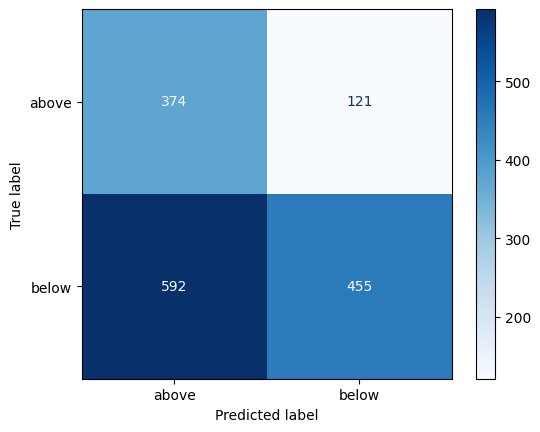

In [ ]:
### 学習開始
!pip install -q tqdm
from tqdm import tqdm
import copy
import torch
from torch import amp
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
import math


POS_CLASS = 0  # "above" がクラスインデックス 0

# best の管理（val_f1 でモデルを選ぶようにする）
best_val_f1 = -1.0
best_state = None
best_threshold_saved = 0.5  # ベストモデル時の閾値を保存

# ------------------------------------------------------
eps = 1e-12
# 一度だけ計算しておく (学習ループの前)
# 各ラベルの頻度
val_data_list_targets = np.array(val_ds.dataset.targets)
val_targets = np.array(val_data_list_targets[val_idx])
val_total_samples = len(val_targets)
val_labels_total_positive = np.bincount(val_targets)[0]
print(f"val_total_samples:{val_total_samples}")
print(f"val_labels_total_positive:{val_labels_total_positive}")


P_train_pos = 0.5 # 訓練時事前確率 サンプラーのせい
P_val_pos   = float((val_labels_total_positive) / (val_total_samples))  # または本番想定比


print(f"P_train_pos:{P_train_pos}")
print(f"P_val_pos:{P_val_pos}")

# 検証ループ外で delta を一回計算
delta = math.log( max(eps, P_val_pos) / max(eps, (1.0-P_val_pos)) ) \
      - math.log( max(eps, P_train_pos) / max(eps, (1.0-P_train_pos)) )

print(f"delta:{delta}")
# -------------------------------------------------------

# 混同行列表示関数
def print_confusion_counts_and_percents(y_true, y_pred, label_names):

    # numpyに変換
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 混同行列計算　ラベル0が陽性、1が陰性
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tp, fn, fp, tn = cm.flatten()  # TP、FN、FP、TN
    total = tp + fn + fp + tn
    if total == 0:
        total = 1  # avoid zero division, though usually shouldn't happen

    def pct(x): return (x / total) * 100.0

    # Print
    print("Confusion matrix (rows=true, cols=pred) with label order:", label_names)
    print(cm)
    print(f"TP: {tp} ({pct(tp):.2f}%)")
    print(f"FN: {fn} ({pct(fn):.2f}%)")
    print(f"FP: {fp} ({pct(fp):.2f}%)")
    print(f"TN: {tn} ({pct(tn):.2f}%)")
    return {"cm": cm, "tp": tp,"fn": fn,"fp": fp,"tn": tn, "total": total}


scaler = amp.GradScaler('cuda')  # 勾配スケーラーを作成
                       # 計算速度向上のため、16bit浮動小数点で計算
                       # 制度が必要な部分のみ32bit浮動小数点で計算

best_val_acc = 0.0 # 正解率の最高値
best_state = None

for epoch in range(num_epochs):
    print(f"[{epoch+1}/{num_epochs}] Training...")
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    # 正解と予測を保存するリスト
    y_true_train = []
    y_pred_train = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} train"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast(): # 16bit浮動小数点で計算、必要な部分のみ32bit
          outputs = model(images)
          loss = criterion(outputs, labels)
          #loss.backward()
          #optimizer.step()


        scaler.scale(loss).backward()     # ← 勾配をスケーリングしてbackward
        scaler.step(optimizer)            # ← スケーリングしたままoptimizer
        scaler.update()                   # ← スケール因子を自動調整

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        running_total += batch_size

        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    epoch_loss = running_loss / running_total
    epoch_acc  = running_corrects / running_total

    # train F1（陽性クラスを POS_CLASS として計算）
    # y_true_train, y_pred_train は 0/1 のラベルなので pos_label に POS_CLASS を渡す
    try:
        train_f1_epoch = f1_score(np.array(y_true_train), np.array(y_pred_train), pos_label=POS_CLASS)
    except Exception as e:
        # 万一計算できない（例: 該当クラスのサンプルがない等）は NaN として扱う
        print("Warning: train F1 could not be computed:", e)
        train_f1_epoch = float("nan")

    print(f"train loss: {epoch_loss:.4f}, train acc: {epoch_acc:.2%}, train F1(pos={POS_CLASS}): {train_f1_epoch:.4f}")

    #print(f"train loss: {epoch_loss:.4f}, train acc: {epoch_acc:.2%}")

    print("Train confusion (epoch):")
    print_confusion_counts_and_percents(y_true_train, y_pred_train, label_names=["above","below"])



    # === validation ===
    model.eval()
    val_running_loss = 0.0
    # val_correct, val_total = 0, 0   # <- val_correct は閾値適用後に計算するのでここでは使わない
    val_total = 0
    y_true_val = []
    # --- collect probs and labels ---
    val_probs_list = []
    val_labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            batch_size = images.size(0)
            val_running_loss += loss.item() * batch_size
            val_total += batch_size

            # ---------------- 検証ループ内（outputs は logits） ----------------
            # そのまま softmax を使う代わりに positive の logit にオフセットを加える
            logits_adj = outputs.clone()
            logits_adj[:, POS_CLASS] = logits_adj[:, POS_CLASS] + delta   # 事前確率補正
            probs = torch.softmax(logits_adj, dim=1)[:, POS_CLASS].detach().cpu().numpy()
            # ----------------------------------------------------------------

            # save logits/probs and labels for threshold tuning
            #probs = torch.softmax(outputs, dim=1)[:, POS_CLASS].detach().cpu().numpy()  # positive class prob
            val_probs_list.append(probs)
            val_labels_list.append(labels.detach().cpu().numpy())

    # concat
    val_probs = np.concatenate(val_probs_list)   # shape (N,)
    val_labels = np.concatenate(val_labels_list) # shape (N,)

    # 1) find best threshold by maximizing F1 on validation (precision-recall curve)
    prec, rec, thresholds = precision_recall_curve((val_labels == POS_CLASS).astype(int), val_probs, pos_label=1)
    if len(thresholds) == 0:
        best_threshold = 0.5
        best_val_f1_epoch = f1_score((val_labels == POS_CLASS).astype(int), (val_probs >= best_threshold).astype(int))
    else:
        f1_scores = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
        best_idx = np.nanargmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_val_f1_epoch = float(f1_scores[best_idx])

    # 閾値表示
    print(f"Validation best threshold (epoch {epoch+1}): {best_threshold:.4f}")

    # 2) apply best_threshold to get preds and metrics
    val_preds_binary = (val_probs >= best_threshold).astype(int)  # 1 == POS_CLASS predicted
    # convert binary back to label indices (0 or 1)
    val_preds = np.where(val_preds_binary == 1, POS_CLASS, 1 - POS_CLASS)

    val_correct = (val_preds == val_labels).sum()
    val_acc = val_correct / val_total
    val_loss = val_running_loss / val_total

    print(f"val loss: {val_loss:.4f}, val acc: {val_acc:.2%}, val F1(pos={POS_CLASS}): {best_val_f1_epoch:.4f}")
    print("Validation confusion (epoch):")
    print_confusion_counts_and_percents(val_labels, val_preds, label_names=["above","below"])

    # 3) モデル保存基準を val_f1 に変更（閾値も保存）
    if best_val_f1_epoch > best_val_f1:
        best_val_f1 = best_val_f1_epoch
        best_state = copy.deepcopy(model.state_dict())
        best_threshold_saved = best_threshold
        print(f"New best val_F1: {best_val_f1:.4f} (model saved, threshold={best_threshold:.4f})")
    # ---------------- end validation block ----------------

# ---------------- test 部分（学習終了後の test） ----------------
if best_state is not None:
    model.load_state_dict(best_state)  # valで最良の重みをロード
    use_threshold = best_threshold_saved
else:
    use_threshold = 0.5

y_true = []
y_pred = []

# test で確率も集めて F1 を計算できるようにする
test_probs_list = []
test_labels_list = []

model.eval()
test_running_loss = 0.0
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        test_running_loss += loss.item() * batch_size
        test_total += batch_size

        # 修正版（validation と同じく delta を適用してから softmax）
        logits_adj = outputs.clone()
        logits_adj[:, POS_CLASS] = logits_adj[:, POS_CLASS] + delta
        probs = torch.softmax(logits_adj, dim=1)[:, POS_CLASS].cpu().numpy()

        test_probs_list.append(probs)
        test_labels_list.append(labels.detach().cpu().numpy())

        #probs = torch.softmax(outputs, dim=1)[:, POS_CLASS].cpu().numpy()
        preds_binary = (probs >= use_threshold).astype(int)
        preds = np.where(preds_binary == 1, POS_CLASS, 1 - POS_CLASS)

        test_correct += (preds == labels.detach().cpu().numpy()).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

test_loss = test_running_loss / test_total
test_acc = test_correct / test_total
print(f"Test loss: {test_loss:.4f}, Test acc%: {test_acc:.2%}, Test acc: {test_acc:.4f}")

# concat test probs/labels として test F1 を算出（use_threshold を使って評価）
test_probs = np.concatenate(test_probs_list)
test_labels = np.concatenate(test_labels_list)
test_y_true_bin = (test_labels == POS_CLASS).astype(int)
test_preds_bin_by_used = (test_probs >= use_threshold).astype(int)
test_f1_by_used = f1_score(test_y_true_bin, test_preds_bin_by_used)

print(f"Test F1 (pos={POS_CLASS}) using threshold {use_threshold:.4f} F1: {test_f1_by_used:.4f}")


# 混同行列を作成
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["above", "below"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()
# ---------------- end test block ----------------
